# **Speculative Decoding**

**LLMs** usually generates the response word by word, while for each generated word it has to look back to all of the previous words (**tokens**) to compute the next word to come. This process with a Target model takes a lot of time and hence the end-user might call the app as slow and leave.



This is when '**Speculative Decoding**' comes handy; It lets the smaller draft model generate the answer that might be a bit inaccurate or hallucinative but super quicker. Bigger target model would check the result of Draft model with its higher wisdom to either accept or reject some of their words. This whole process helps reduce the latency per token from **~80ms** to **~30ms**, which is quite effective when considered in the whole pipeline

### Installing the required libraries

In [1]:
!pip install -U transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


We are going to test it with smaller models that are able to fit in the RAM of Colab's free version T4 GPU. For this purpose we are going to select **Llama-3.2-3B-Instruct** & **Llama-3.2-1B-Instruct** as target and draft models respectively.


For this make sure you have Been granted access from huggingface and have the necessary huggingdace API. Define your API by pressing the "key" icon on the left panee. Give the variable name as **"HF_TOKEN"** & the API KEY as the value.

In [2]:
import os
hf_token = os.environ.get("HF_TOKEN")

if hf_token:
    print("Hugging Face API token loaded successfully from environment variable.")
else:
    print("Hugging Face API token not available.")

Hugging Face API token not available.


In [ ]:
import torch
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

target_model = "meta-llama/Llama-3.2-3B-Instruct"
draft_model = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(target_model)
model = AutoModelForCausalLM.from_pretrained(target_model, torch_dtype=torch.float16, device_map="cuda")
draft_model = AutoModelForCausalLM.from_pretrained(draft_model, torch_dtype=torch.float16, device_map="cuda")

Just as you ask different length of sentences when using Gemini or ChatGPT, your production app is expected to behave the same way. Lets try a **targert_len** of **800 token** to be generated and compare speculative decoding with the standard one.

The key is in using the inpour argument of **assitant_model** as;


`assistant_model=draft_model if use_assistant else None`

This is a built-in method by Transformers for **specualtive decoding**.

In [4]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt


prompt = """
Write a massive, 800-token SQL schema and Python ETL pipeline for a
global logistics company. Include tables for 'shipments', 'sensors',
'drivers', and 'warehouses'. Write long docstrings for every function
and complex nested joins in the SQL queries.
"""
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
target_len = 800

def run_extreme_benchmark(use_assistant):
    torch.cuda.empty_cache()
    start_time = time.time()

    outputs = model.generate(
        input_ids,
        assistant_model=draft_model if use_assistant else None,
        num_assistant_tokens=10, # The 'K' factor. 10 guesses per cycle.
        max_new_tokens=target_len,
        do_sample=False,
        temperature=None, # Pure greedy for max stability
        top_p=None
    )

    end_time = time.time()
    total_time = end_time - start_time
    actual_tokens = outputs.shape[1] - input_ids.shape[1]

    return np.linspace(0, total_time, actual_tokens)

## **Plot the Inference **

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Passing `generation_config` together with generation-related arguments=({'max_new_tokens', 'min_new_tokens', 'use_cache'}) i

Total Time Saved: 28.60 seconds!


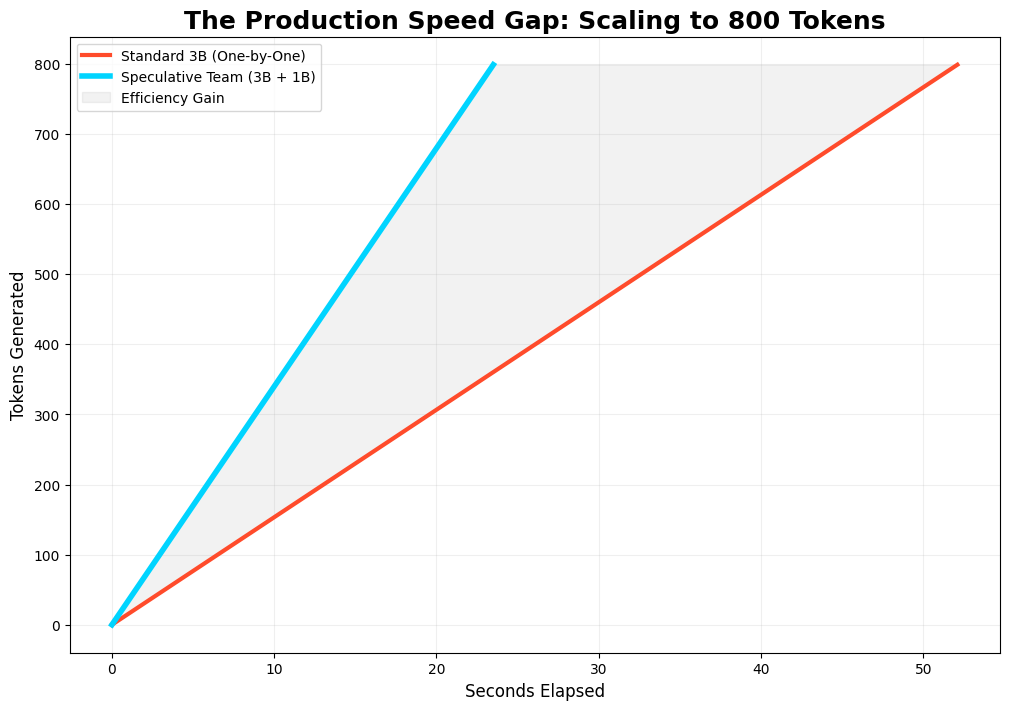

In [5]:

std_trace = run_extreme_benchmark(False)

spec_trace = run_extreme_benchmark(True)

plt.figure(figsize=(12, 8), facecolor='white')
plt.plot(std_trace, np.arange(len(std_trace)), color='#FF4B2B', label='Standard 3B (One-by-One)', lw=3)
plt.plot(spec_trace, np.arange(len(spec_trace)), color='#00D4FF', label='Speculative Team (3B + 1B)', lw=4)

plt.fill_betweenx(np.arange(len(spec_trace)), spec_trace, std_trace[:len(spec_trace)],
                 color='gray', alpha=0.1, label='Efficiency Gain')

plt.title("The Production Speed Gap: Scaling to 800 Tokens", fontsize=18, fontweight='bold')
plt.xlabel("Seconds Elapsed", fontsize=12)
plt.ylabel("Tokens Generated", fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.2)

savings = std_trace[-1] - spec_trace[-1]
print(f"Total Time Saved: {savings:.2f} seconds!")
plt.show()

# Analyzing Results

Latency of That much difference is key in Production. its has a critical impact to decide if either you have a good Inference Engine or not.

For a Bigger Generation of **800 Words(Tokens)**, the latency is standing alone at more than **10 seconds**.

In Production, there is alot more to it. I ill be expalaining some more of the other key factors in the next ones.
